# NLP Project

In [1]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

## Download of the Dataset

In [2]:
from utils.seeder import set_random_seed
SEED = 42

set_random_seed(SEED)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from utils.dataset_builder import get_dataframes

arguments_train_df, labels_train_df = get_dataframes('data', 'training')
arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [4]:
print('Arguments dataframe structure:')
arguments_train_df.head()

Arguments dataframe structure:


Conclusion       Stance  \
0                  We should ban human cloning  in favor of   
1                      We should ban fast food  in favor of   
2  We should end the use of economic sanctions      against   
3         We should abolish capital punishment      against   
4                We should ban factory farming      against   

                                             Premise  \
0  we should ban human cloning as it will only ca...   
1  fast food should be banned because it is reall...   
2  sometimes economic sanctions are the only thin...   
3  capital punishment is sometimes the only optio...   
4  factory farming allows for the production of c...   

                                              Labels  
0                               [Security: societal]  
1                               [Security: personal]  
2             [Power: dominance, Security: societal]  
3  [Security: societal, Conformity: rules, Univer...  
4  [Security: personal, Benevolence: caring, Univ...

In [5]:
print('Labels dataframe structure:')
labels_train_df.head()

Labels dataframe structure:


Self-direction: thought  Self-direction: action  Stimulation  Hedonism  \
0                        0                       0            0         0   
1                        0                       0            0         0   
2                        0                       0            0         0   
3                        0                       0            0         0   
4                        0                       0            0         0   

   Achievement  Power: dominance  Power: resources  Face  Security: personal  \
0            0                 0                 0     0                   0   
1            0                 0                 0     0                   1   
2            0                 1                 0     0                   0   
3            0                 0                 0     0                   0   
4            0                 0                 0     0                   1   

   Security: societal  Tradition  Conformity: rules  \
0                   1          0                  0   
1                   0          0                  0   
2                   1          0                  0   
3                   1          0                  1   
4                   0          0                  0   

   Conformity: interpersonal  Humility  Benevolence: caring  \
0                          0         0                    0   
1                          0         0                    0   
2                          0         0                    0   
3                          0         0                    0   
4                          0         0                    1   

   Benevolence: dependability  Universalism: concern  Universalism: nature  \
0                           0                      0                     0   
1                           0                      0                     0   
2                           0                      0                     0   
3                           0                      1                     0   
4                           0                      1                     0   

   Universalism: tolerance  Universalism: objectivity  
0                        0                          0  
1                        0                          0  
2                        0                          0  
3                        0                          0  
4                        0                          0

In [6]:
print(f'Number of rows of the train dataframe: {len(arguments_train_df)}')
print(f'Number of rows of the test dataframe: {len(arguments_test_df)}')

Number of rows of the train dataframe: 5393
Number of rows of the test dataframe: 1896


In [7]:
TARGETS = labels_train_df.columns.to_list()

In [8]:
print(f'Number of classes: {len(TARGETS)}')

Number of classes: 20


In [9]:
from utils.dataset_builder import split_dataframes

(arguments_train_df, labels_train_df), (arguments_val_df, labels_val_df) = split_dataframes(
    arguments_train_df, labels_train_df, seed=SEED)

In [10]:
print(f'Number of rows of the train dataframe after splitting: {len(arguments_train_df)}')
print(f'Number of rows of the validation dataframe after splitting: {len(arguments_val_df)}')

Number of rows of the train dataframe after splitting: 4314
Number of rows of the validation dataframe after splitting: 1079


# Data Analysis

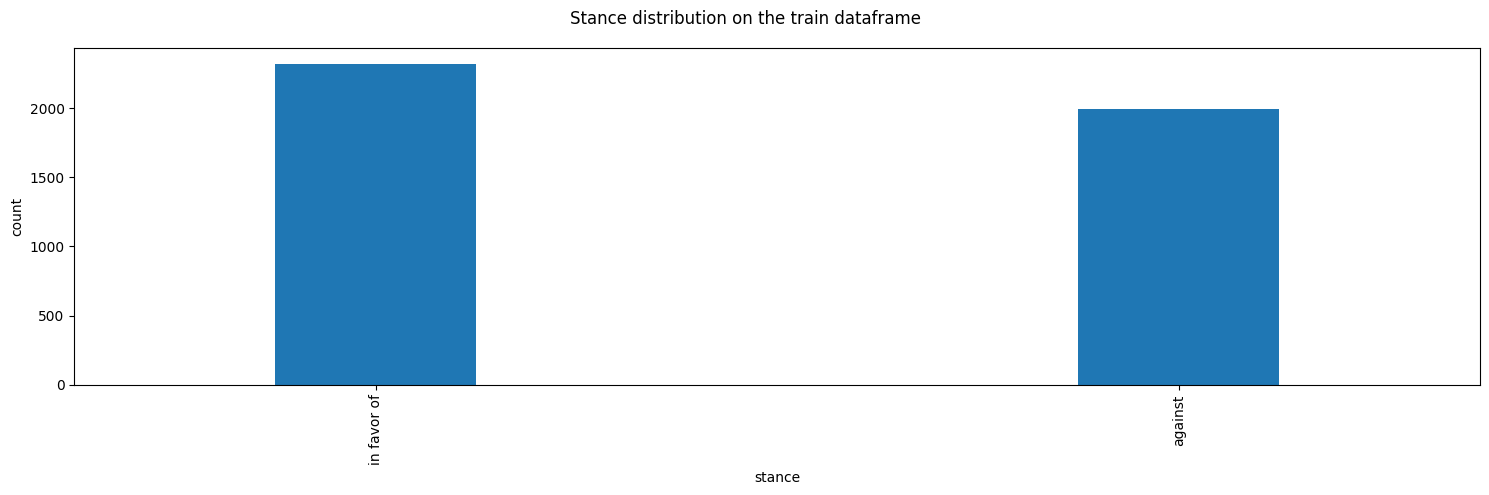

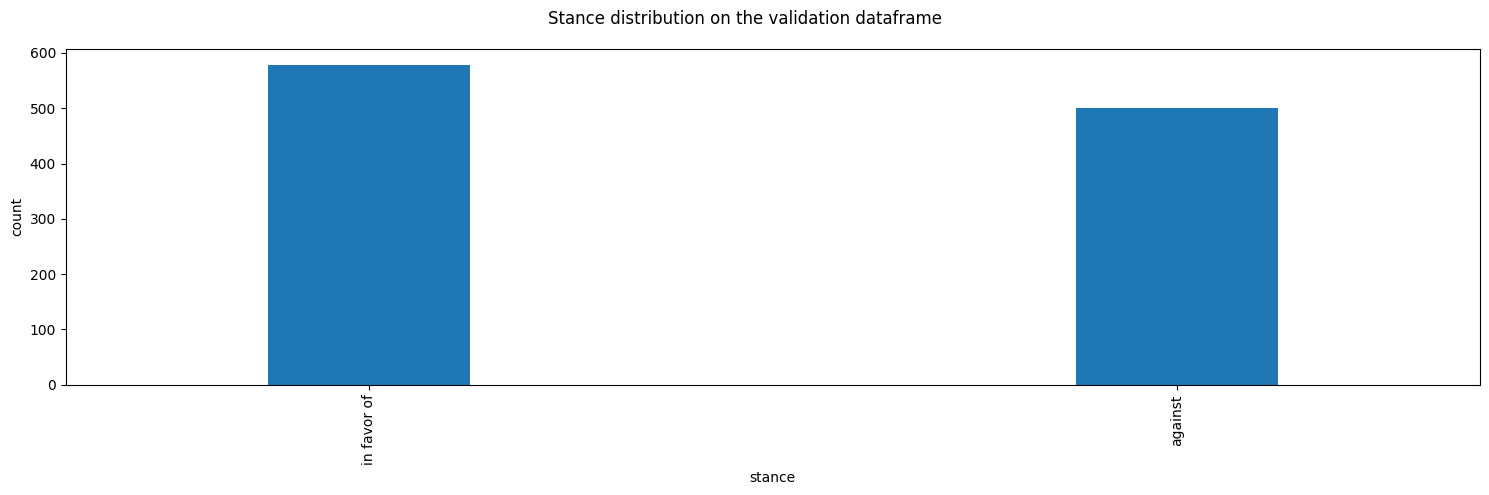

In [11]:
from utils.dataset_analysis import plot_stance_distribution

plot_stance_distribution(arguments_train_df, title='Stance distribution on the train dataframe')
plot_stance_distribution(arguments_val_df, title='Stance distribution on the validation dataframe')

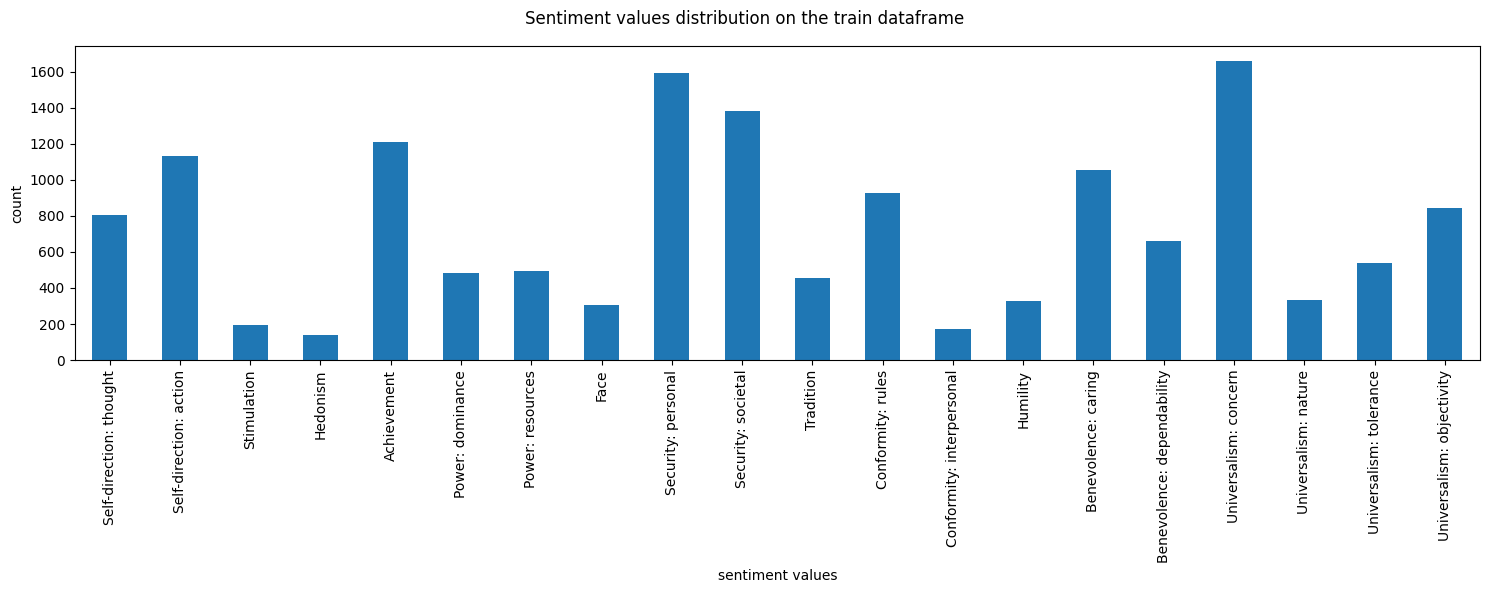

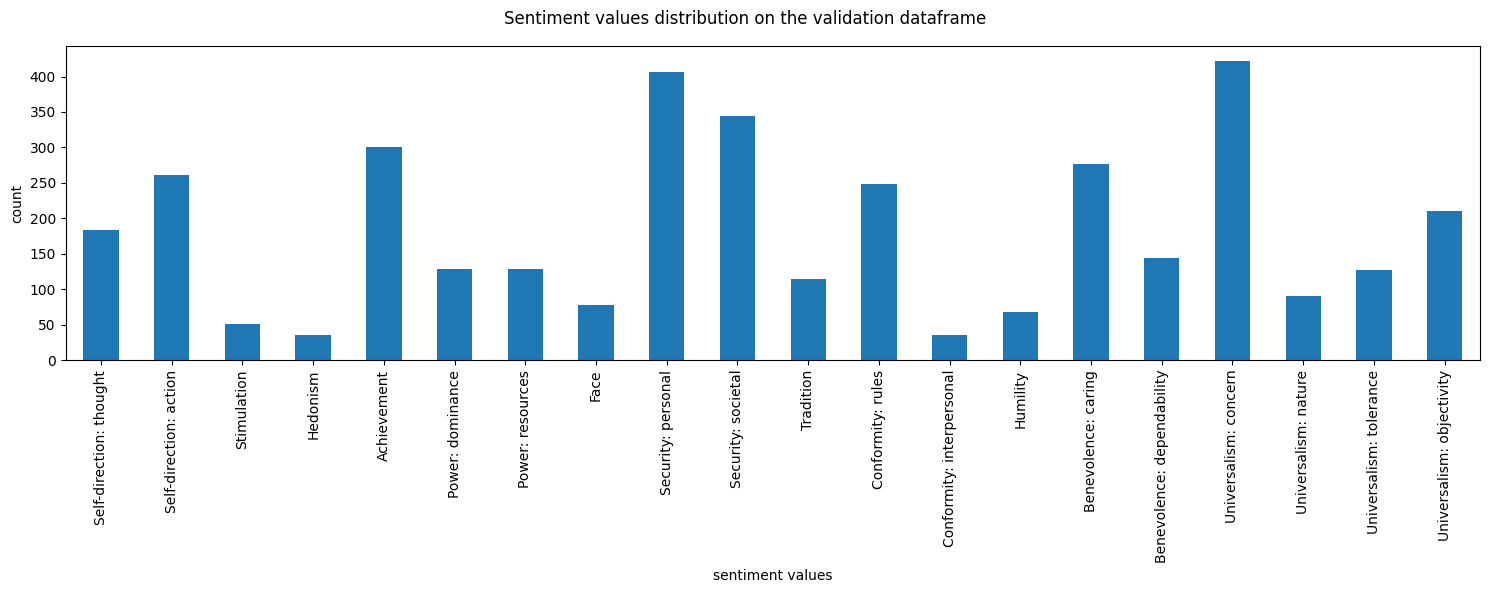

In [12]:
from utils.dataset_analysis import plot_sentiment_distribution

plot_sentiment_distribution(labels_train_df, title='Sentiment values distribution on the train dataframe')
plot_sentiment_distribution(labels_val_df, title='Sentiment values distribution on the validation dataframe')

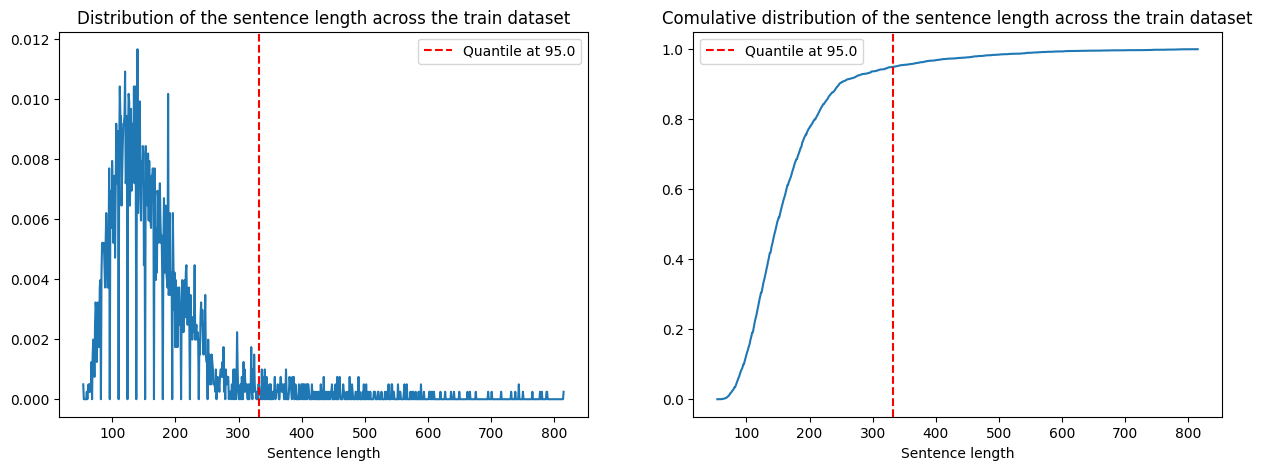

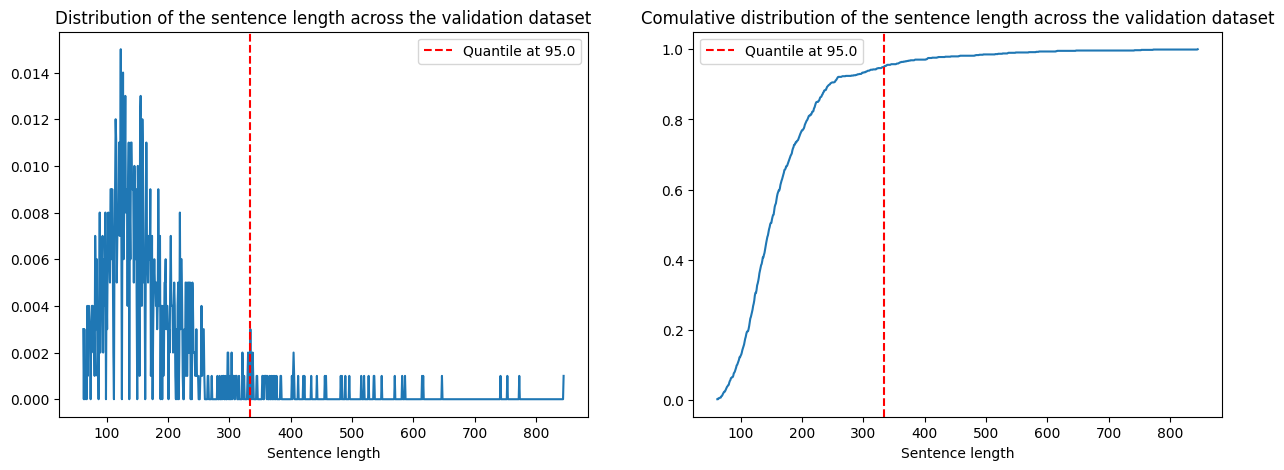

In [13]:
from utils.dataset_analysis import plot_sequence_length_analysis

plot_sequence_length_analysis(arguments_train_df, df_name='train dataset', percentile=.95)
plot_sequence_length_analysis(arguments_val_df, df_name='validation dataset', percentile=.95)

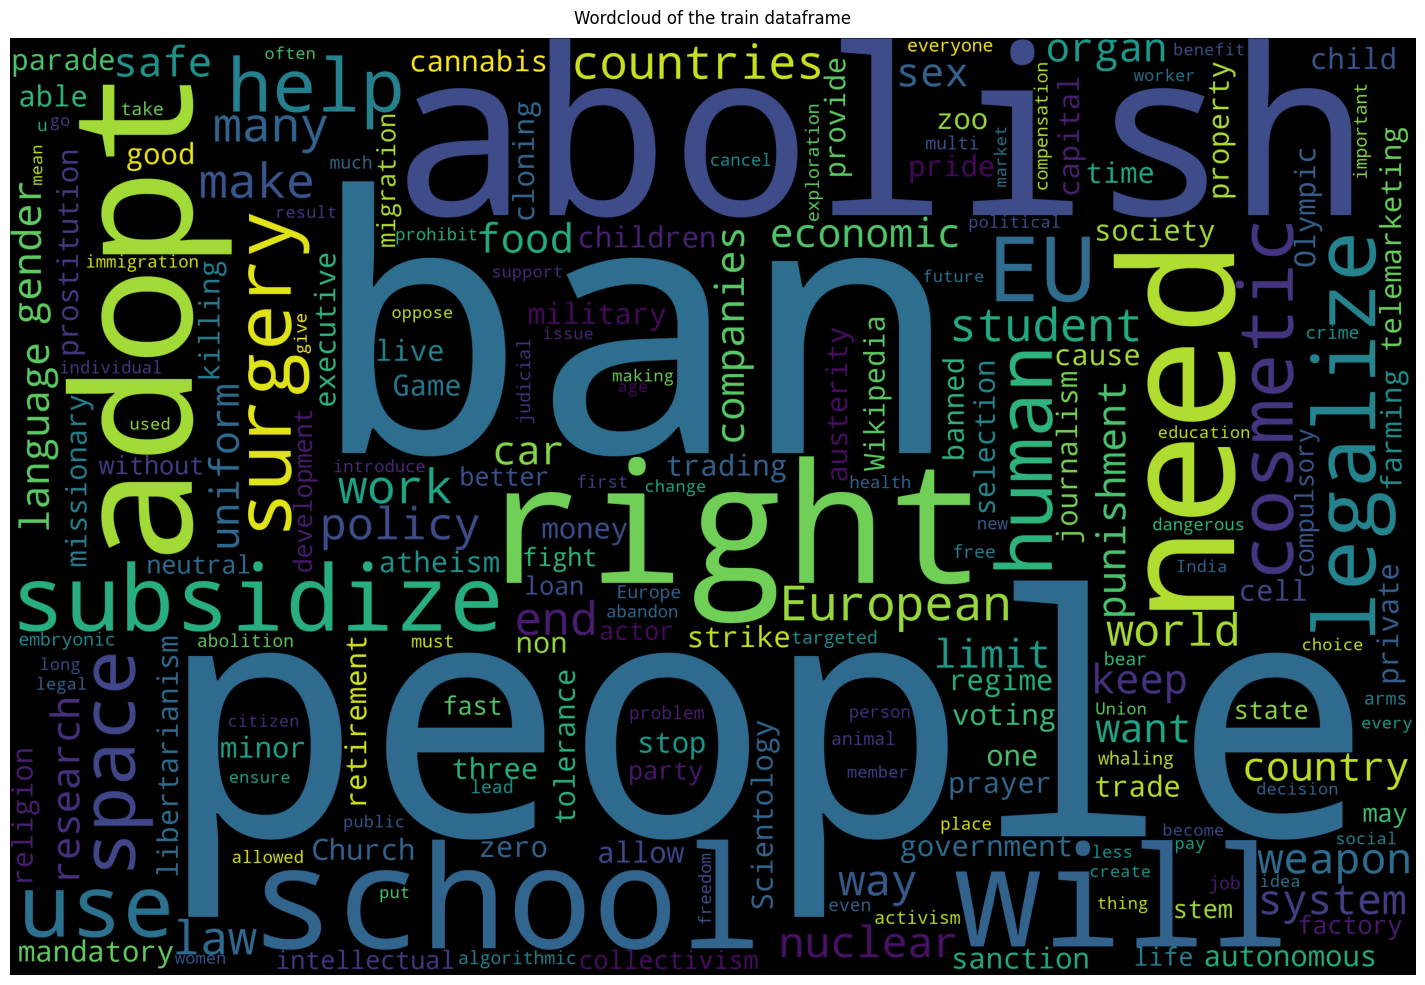

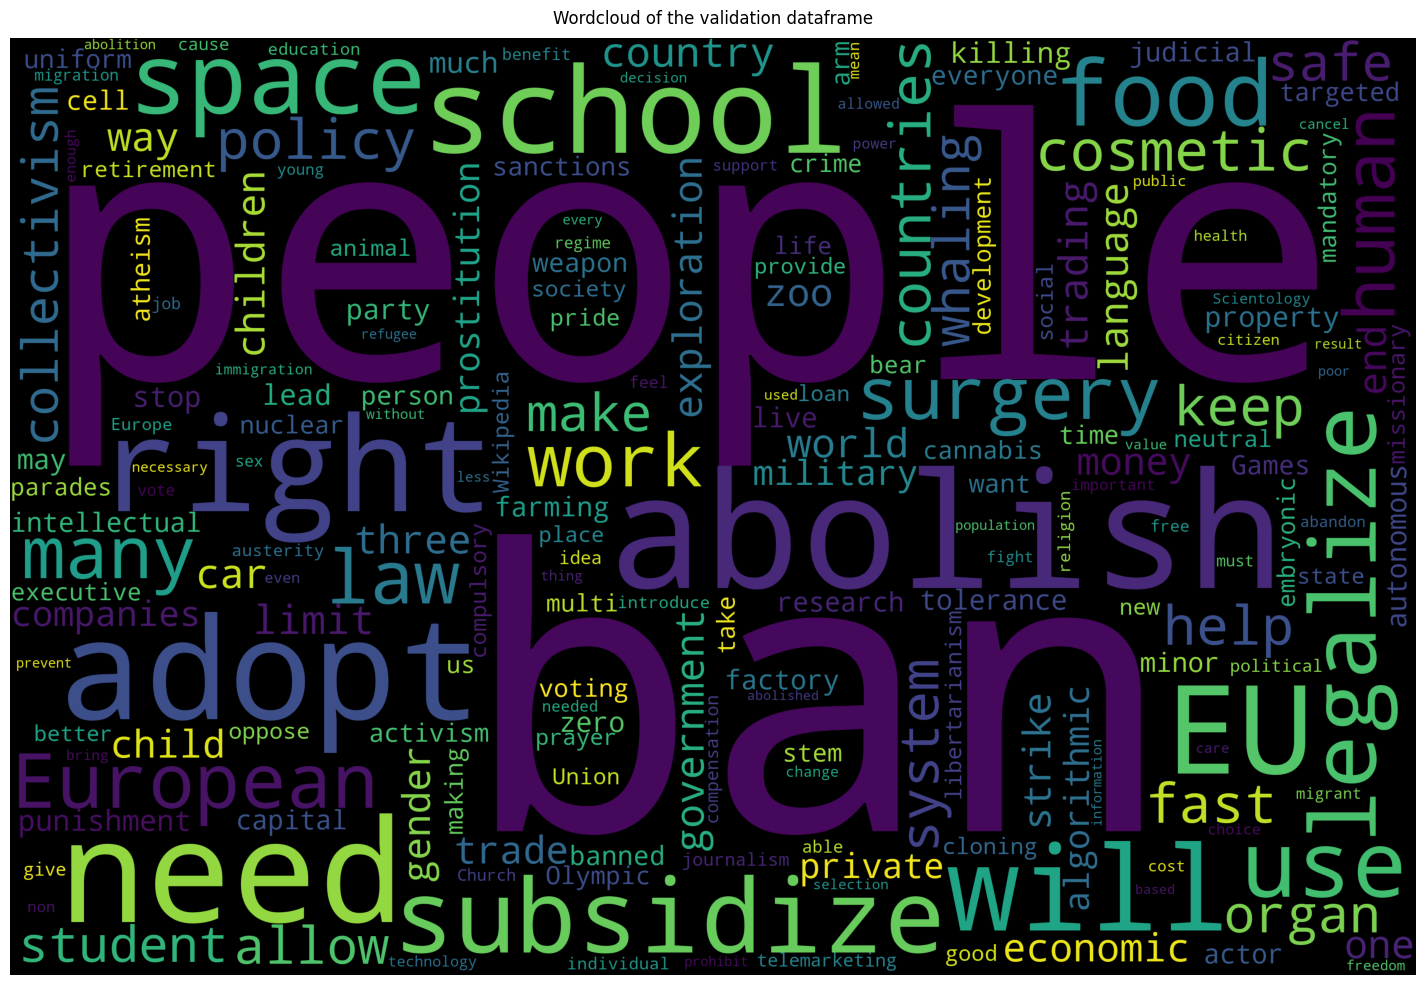

In [14]:
from utils.dataset_analysis import plot_word_cloud

plot_word_cloud(arguments_train_df, title='Wordcloud of the train dataframe')
plot_word_cloud(arguments_val_df, title='Wordcloud of the validation dataframe')

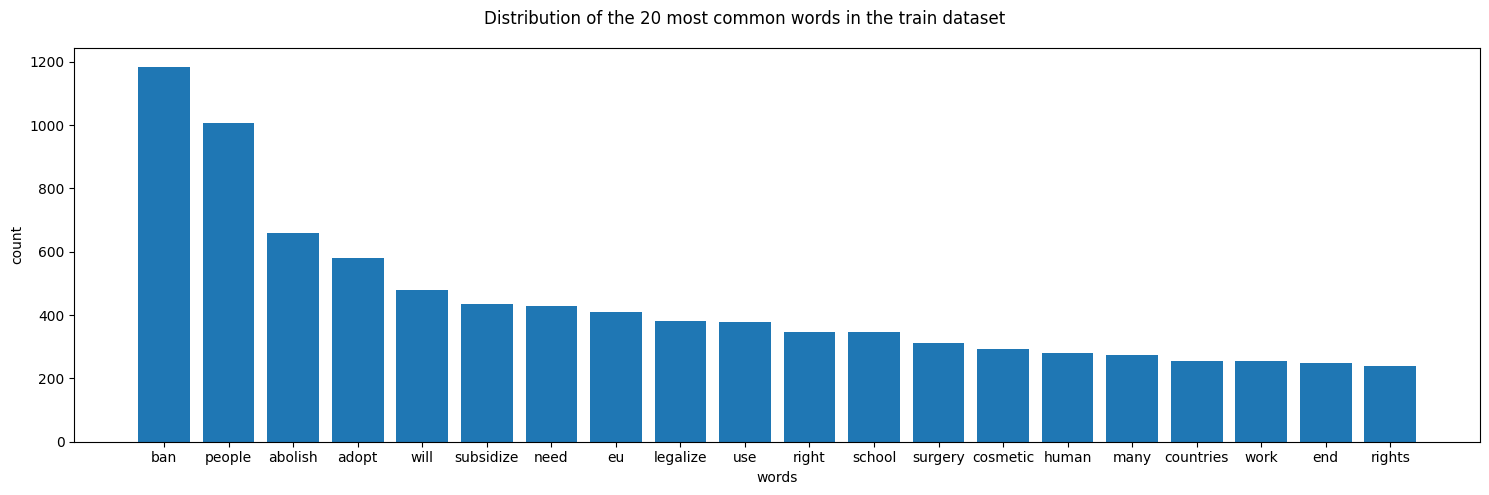

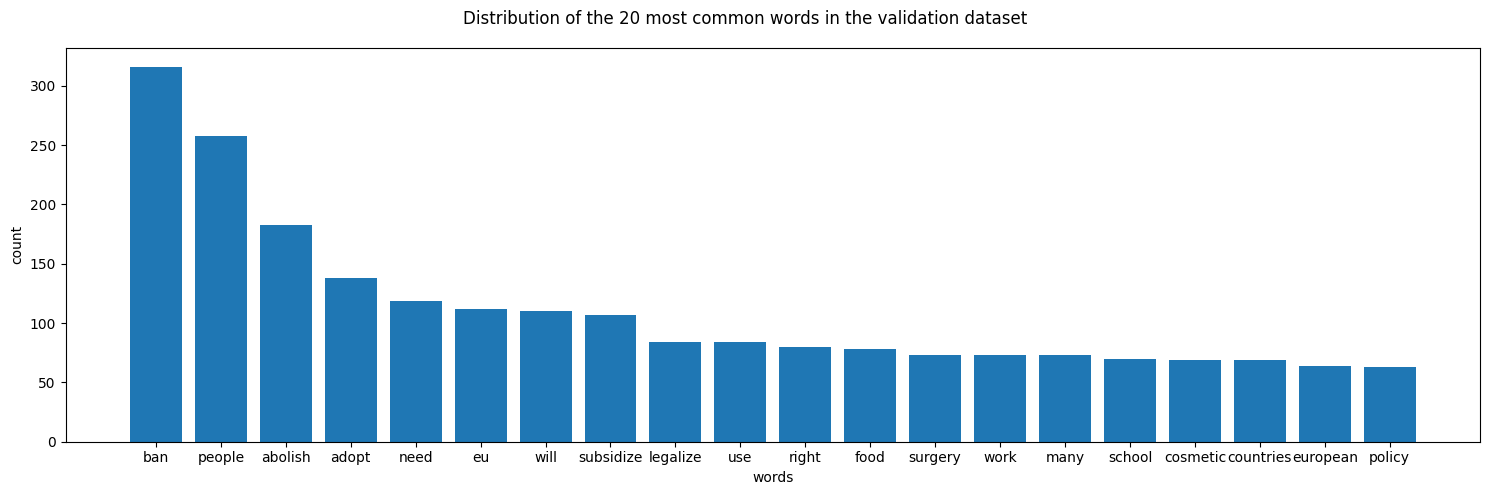

In [15]:
from utils.dataset_analysis import plot_most_common_words_distribution

plot_most_common_words_distribution(arguments_train_df, n=20,
                                    title='Distribution of the 20 most common words in the train dataset')
plot_most_common_words_distribution(arguments_val_df, n=20,
                                    title='Distribution of the 20 most common words in the validation dataset')

# Model and Tokenizer Definition

In [16]:
from torch import cuda
from transformers import logging

MODEL_NAME = 'roberta-base'
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set verbosity at "error" level
logging.set_verbosity_error()

In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, problem_type='multi_label_classification')
tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True)

stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

In [18]:
from models.main_model import get_main_model

model = get_main_model(MODEL_NAME, num_labels=len(TARGETS), tokenizer=tokenizer, device=DEVICE)

In [19]:
print('Model structure:')
print(model)

Model structure:
RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50267, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

## Training

### Create Dataloaders

In [20]:
'''TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE_BASE = 1e-05
LEARNING_RATE_HEAD = 1e-03''';

In [21]:
from utils.dataloader_builder import get_dataloader

train_loader = get_dataloader(arguments_train_df, labels_train_df, tokenizer, batch_size=8,
                   shuffle=True, use_augmentation=True)
val_loader = get_dataloader(arguments_val_df, labels_val_df, tokenizer, batch_size=16,
                   shuffle=False, use_augmentation=False)
test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer, batch_size=16,
                   shuffle=False, use_augmentation=False)

### Training parameters

In [22]:
from torch.optim import Adam
from utils.training_utils import FocalLoss, Checkpoint, EarlyStopping

# Define loss function
train_labels_frequencies = (labels_train_df.sum() / len(labels_train_df)).to_numpy()
loss_function = FocalLoss(alpha=train_labels_frequencies, gamma=1.5)

# Define the optimizer
optimizer = Adam(params=[
    {'params': model.roberta.parameters(), 'lr': 1e-05},
    {'params': model.classifier.parameters(), 'lr': 1e-03}])

# Define the checkpoints and the early stopping monitor
checkpoint = Checkpoint(model)
early_stopping = EarlyStopping()

### Training

In [23]:
from utils.training import train

train_loss_history, val_loss_history, val_f1_macro_history = train(train_loader, val_loader, model, optimizer, loss_function,
                                                                   DEVICE, epochs=10, steps_validate=200,
                                                                   checkpoint=checkpoint, early_stopping=early_stopping,
                                                                   reload_best_weights=True)

epoch: 1/10, 199/540, 31s 154ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0617,                
validate: 5s, validation loss: 0.0542, validation f1 macro: 40.4 %               
epoch: 1/10, 399/540, 64s 161ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0589,                
validate: 5s, validation loss: 0.0507, validation f1 macro: 44 %               
epoch: 1/10, 540/540, 92s 171ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0577,                
-----------------------------------------------------------------------------------------------
epoch: 1/10, 92s, lr base: 1e-05 lr head: 0.001, loss: 0.0577 val loss:, 0.0515, val f1 macro: 41 %
epoch: 2/10, 199/540, 28s 143ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0526,                
validate: 5s, validation loss: 0.0495, validation f1 macro: 45.6 %               
epoch: 2/10, 399/540, 63s 159ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0524,                
validate: 5s, validation loss: 0.0504, validation f1 macro: 44.6 

In [45]:
'''checkpoint = torch.load('checkpoints/best_model.pth')

# Get loss history and validation loss history
model.load_state_dict(checkpoint['model_state_dict'][0])
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']
val_f1_macro_history = checkpoint['val_f1_macro_history']''';

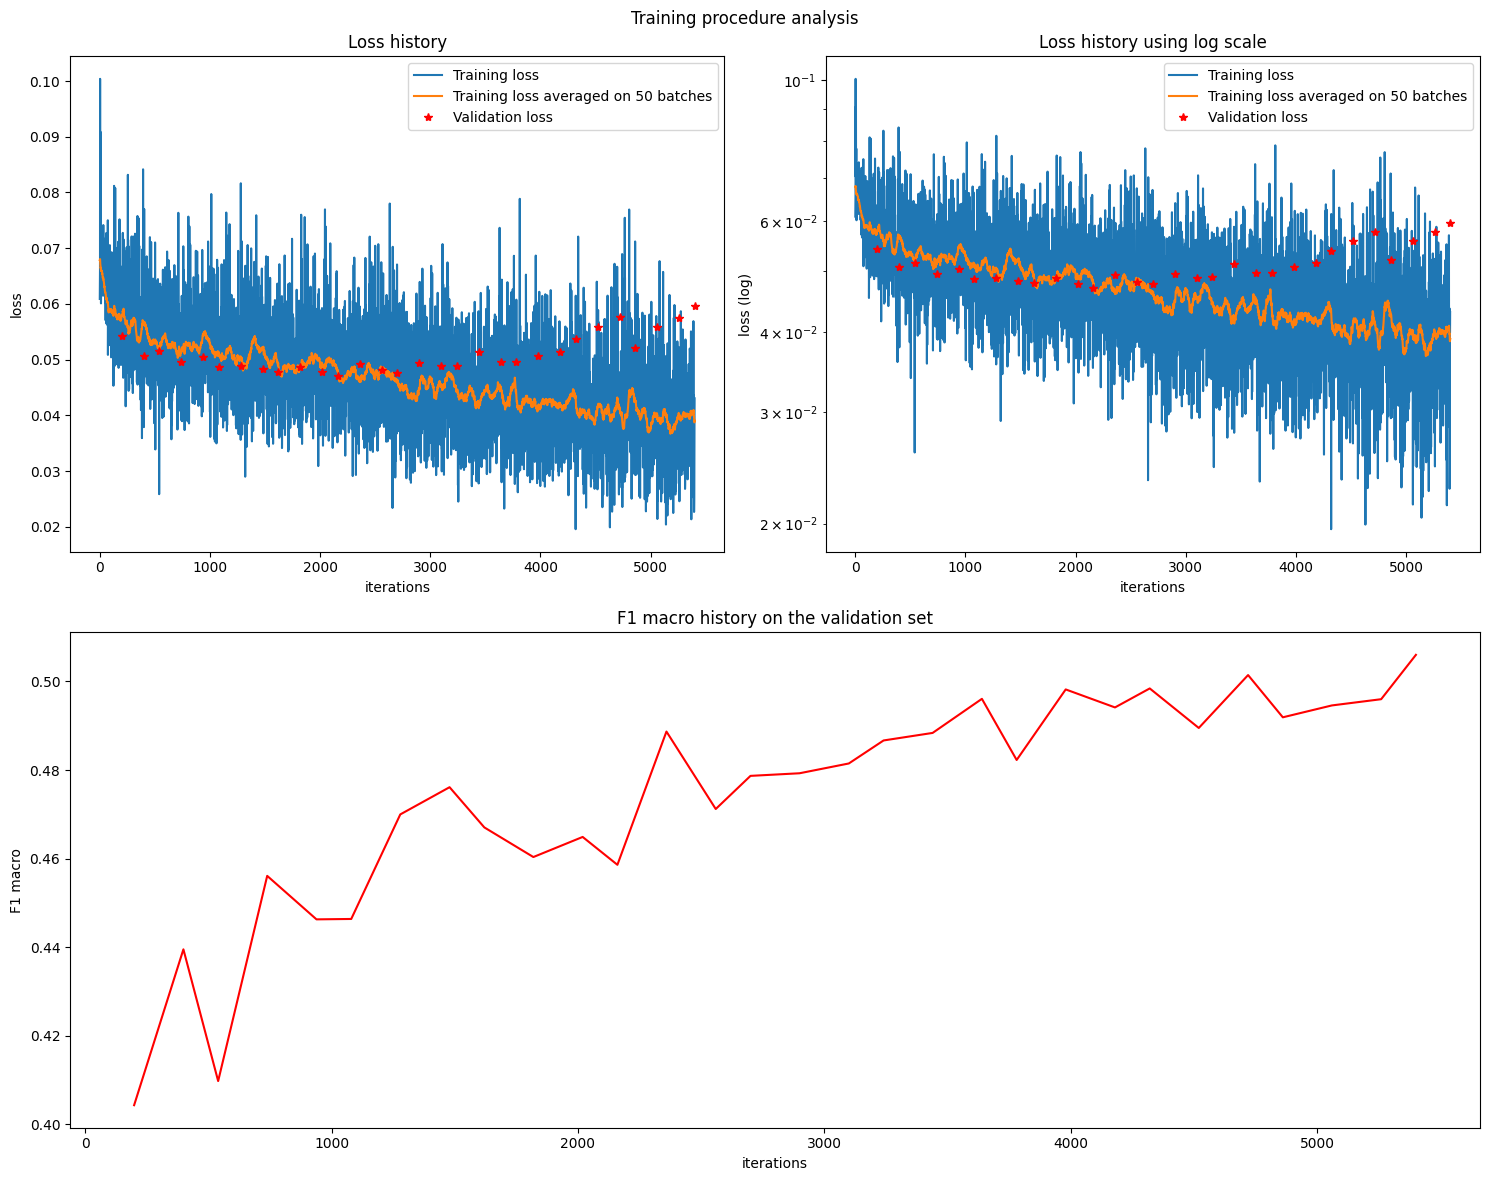

In [24]:
from utils.training_analysis import plot_training_history

plot_training_history(train_loss_history, val_loss_history, val_f1_macro_history)

# Model Evaluation

## Threshold selection

In [29]:
import torch
from utils.evaluation import get_dataset_predictions

In [32]:
preds, y_true = get_dataset_predictions(model, val_loader, DEVICE)

preds = torch.tensor(preds)
y_true = torch.tensor(y_true)

# Argsort elements by column
idx = torch.argsort(preds, 0)

# Sort predictions based on argsort
s_preds = torch.gather(preds, 0, idx)
s_true = torch.gather(y_true, 0, idx)

In [48]:
c_positive = torch.cumsum(s_true, 0)
c_negative = torch.cumsum(1 - s_true, 0)

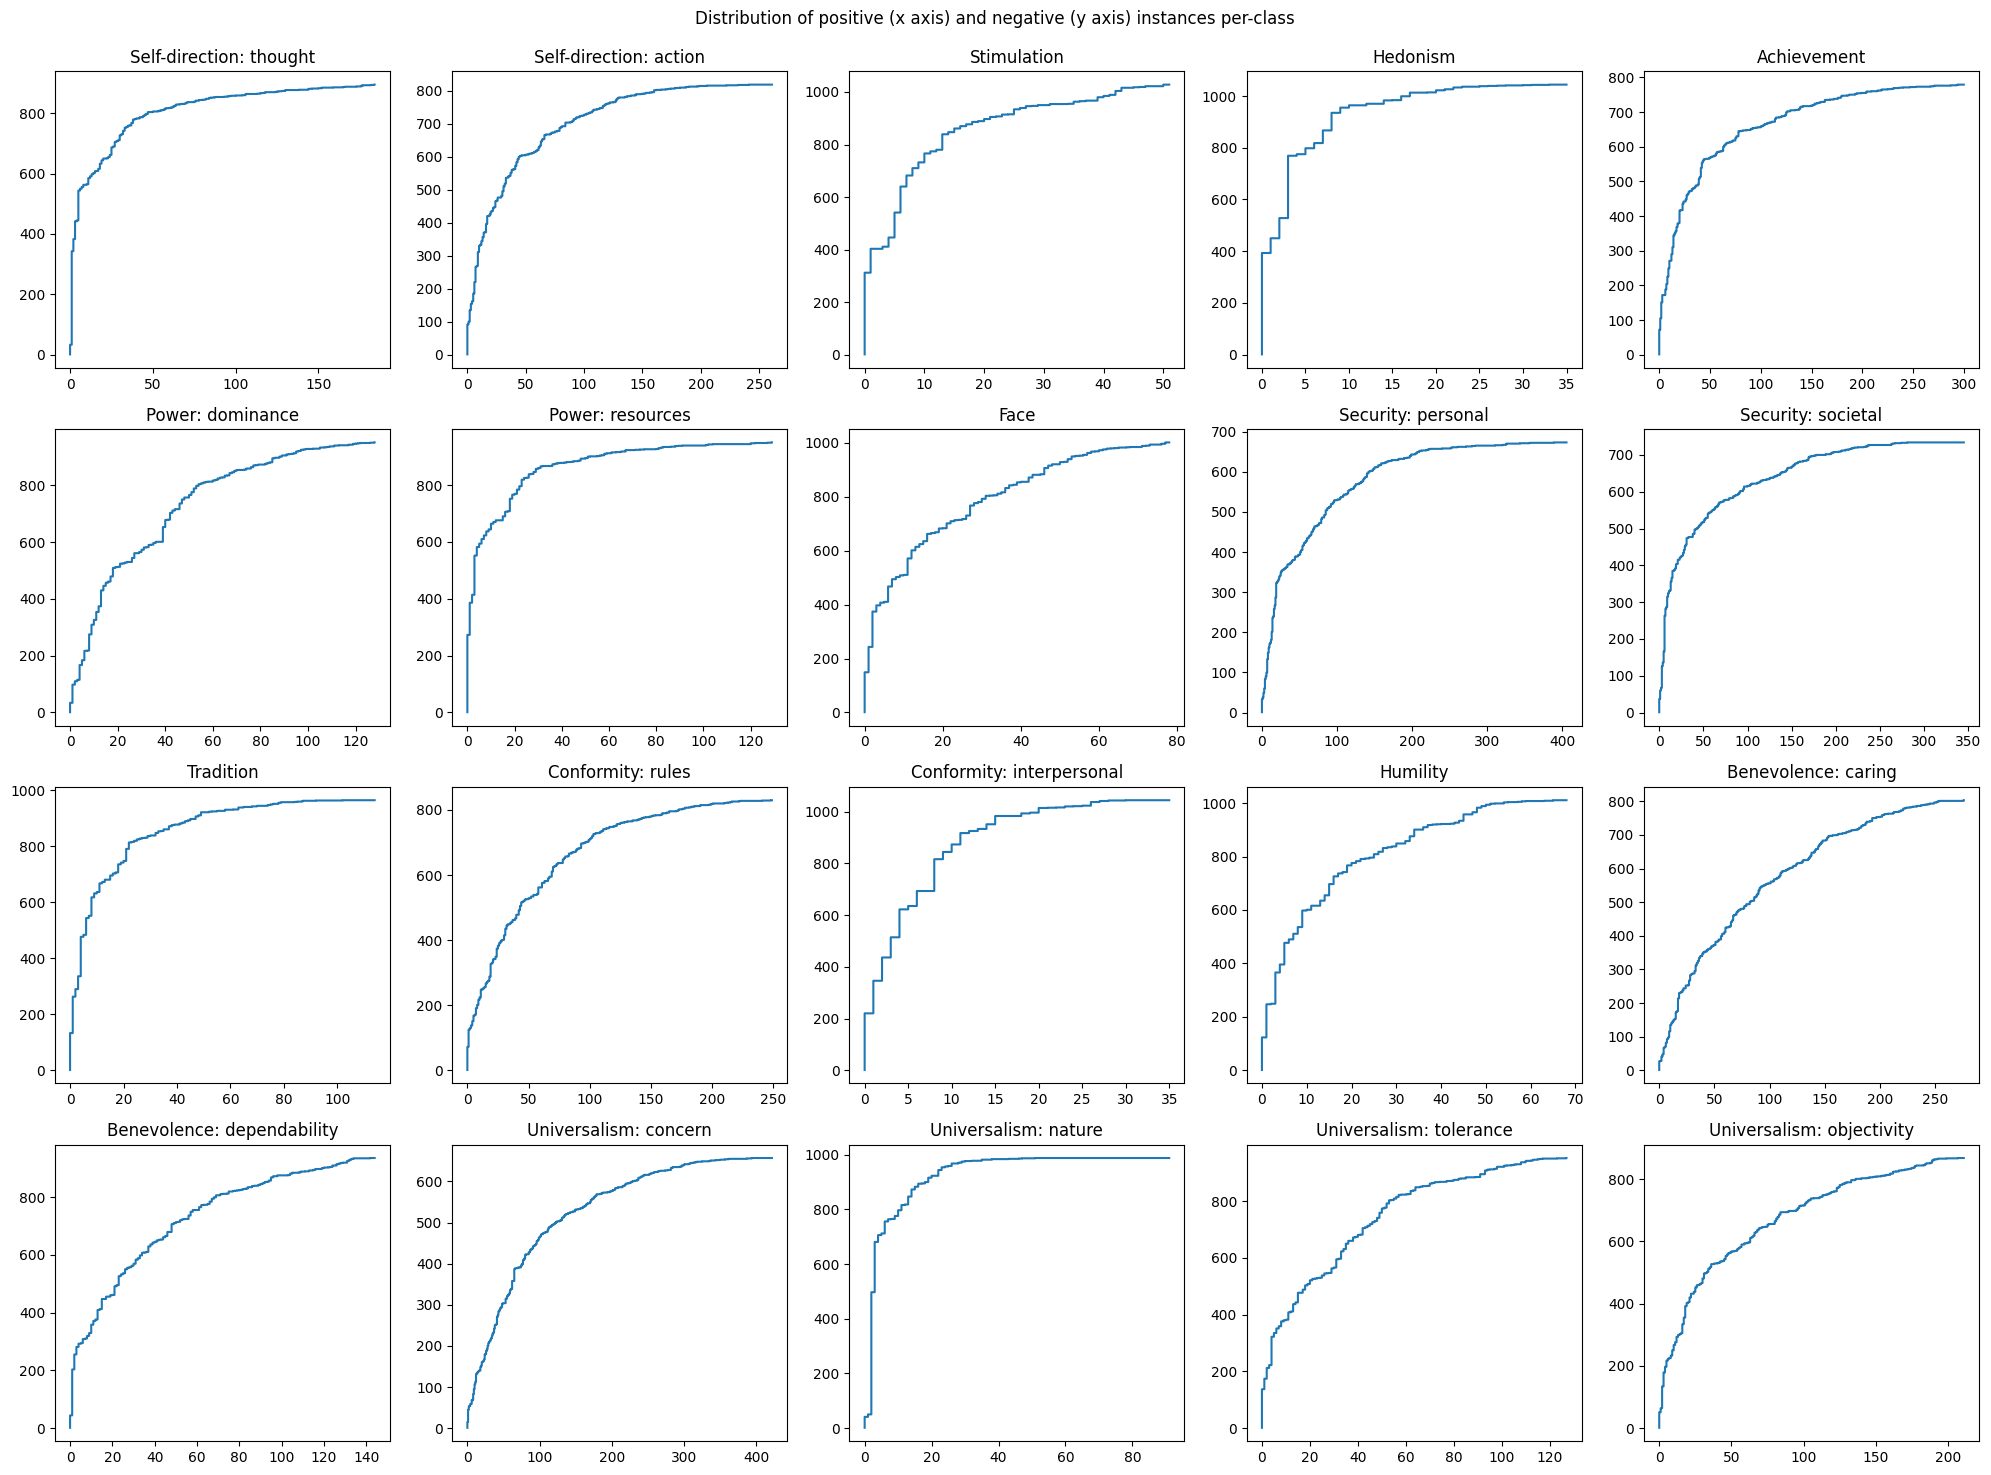

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.suptitle('Distribution of positive (x axis) and negative (y axis) instances per-class\n')
for i, l in enumerate(TARGETS):
    ax = plt.subplot(4, 5 , i + 1)
    ax.set_title(l)
    ax.plot(c_positive[:,i], c_negative[:,i])
plt.tight_layout()
plt.show()

torch.Size([1079, 20])


In [65]:
# Cumulative sum of positive elements for each class at 
c_true_positive = c_positive[-1:] - c_positive

R = (torch.arange(len(c_true_positive)) + 1)[:,None]
c_precision = c_true_positive / (R[-1] - R + 1) + 1e-7
c_recall = c_true_positive / (c_true_positive[:1] + 1e-7) + 1e-7
c_F1 = 2 * (c_precision * c_recall) / (c_precision + c_recall)

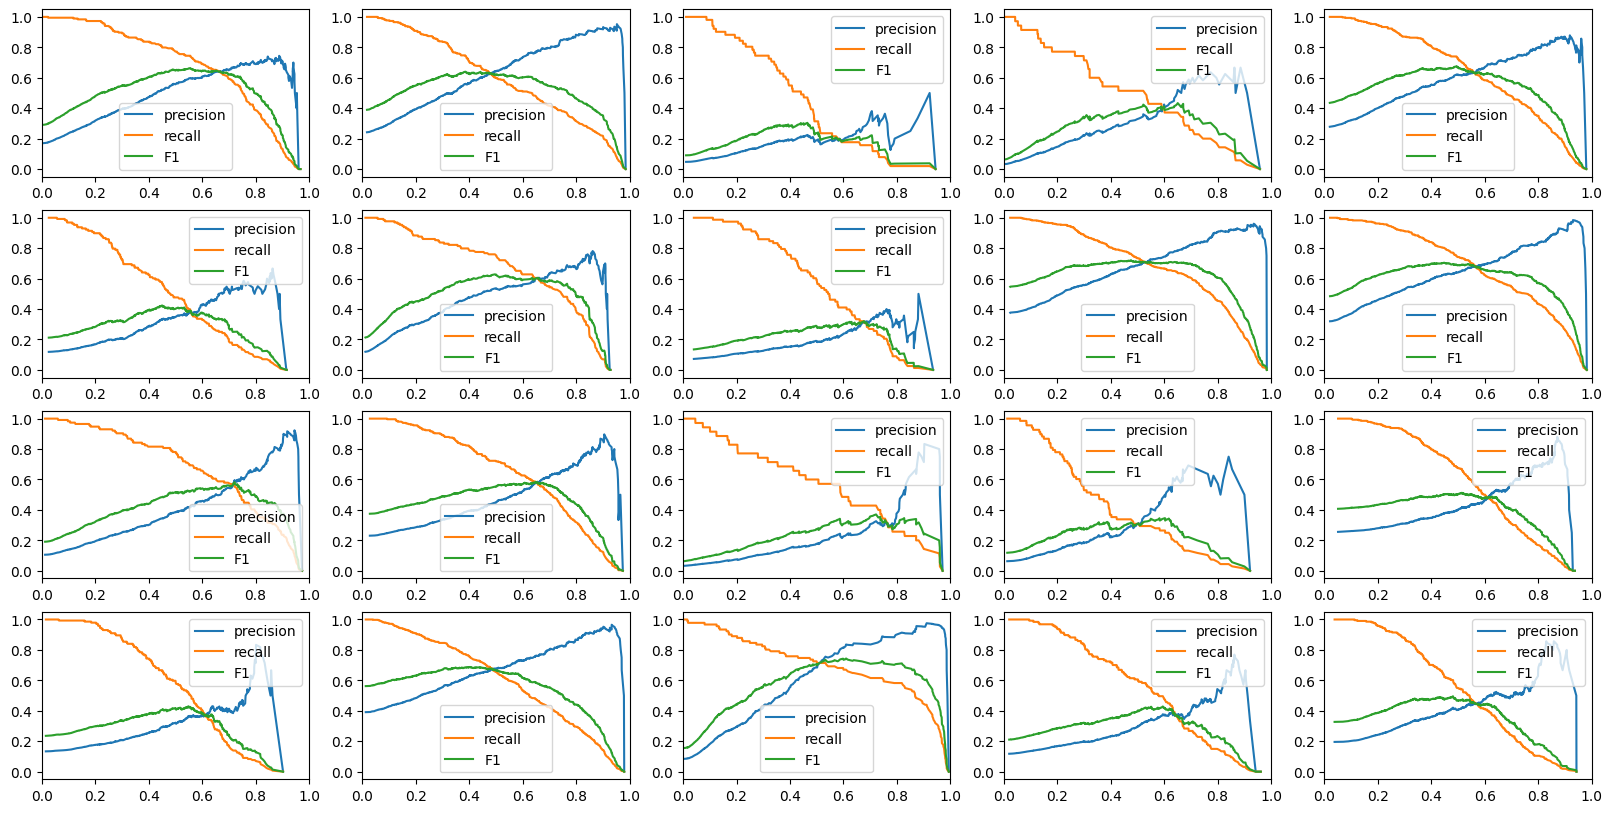

In [66]:
plt.figure(figsize=(20,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(torch.sigmoid(s_preds[:,i]),c_precision[:,i],label='precision')
    plt.plot(torch.sigmoid(s_preds[:,i]),c_recall[:,i],label='recall')
    plt.plot(torch.sigmoid(s_preds[:,i]),c_F1[:,i], label='F1')
    plt.xlim(0,1)
    plt.legend()

In [67]:
import numpy as np
idx_max = c_F1.argmax(0)
threshold=[s_preds[idx,i] for i, idx in enumerate(idx_max)]
threshold=np.array(threshold)

## Evaluation on the Validation set

In [68]:
# Validation f1-score
from sklearn.metrics import f1_score
from utils.evaluation import predict

y_pred, y_true = predict(model, val_loader, DEVICE)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Validation f1-score macro on the validation set with base threshold 0: {f1_macro:.3f}')

Validation f1-score macro on the validation set with base threshold 0: 0.506


In [70]:
# Validation f1-score + threshold
from sklearn.metrics import f1_score
from utils.evaluation import predict

#for i in np.linspace(-)

y_pred, y_true = predict(model, val_loader, DEVICE, threshold)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Validation f1-score macro on the validation set with threshold selection: {f1_macro:.3f}')

Validation f1-score macro on the validation set with threshold selection: 0.537


In [77]:
from utils.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'validation')

Classification report for the validation set
                            precision    recall  f1-score   support

   Self-direction: thought       0.60      0.74      0.67       184
    Self-direction: action       0.56      0.75      0.64       261
               Stimulation       0.23      0.47      0.31        51
                  Hedonism       0.54      0.37      0.44        35
               Achievement       0.62      0.74      0.68       300
          Power: dominance       0.33      0.58      0.42       128
          Power: resources       0.54      0.76      0.63       129
                      Face       0.32      0.32      0.32        78
        Security: personal       0.68      0.76      0.72       406
        Security: societal       0.63      0.80      0.71       345
                 Tradition       0.60      0.57      0.59       114
         Conformity: rules       0.58      0.59      0.59       249
 Conformity: interpersonal       0.33      0.43      0.38        35
  

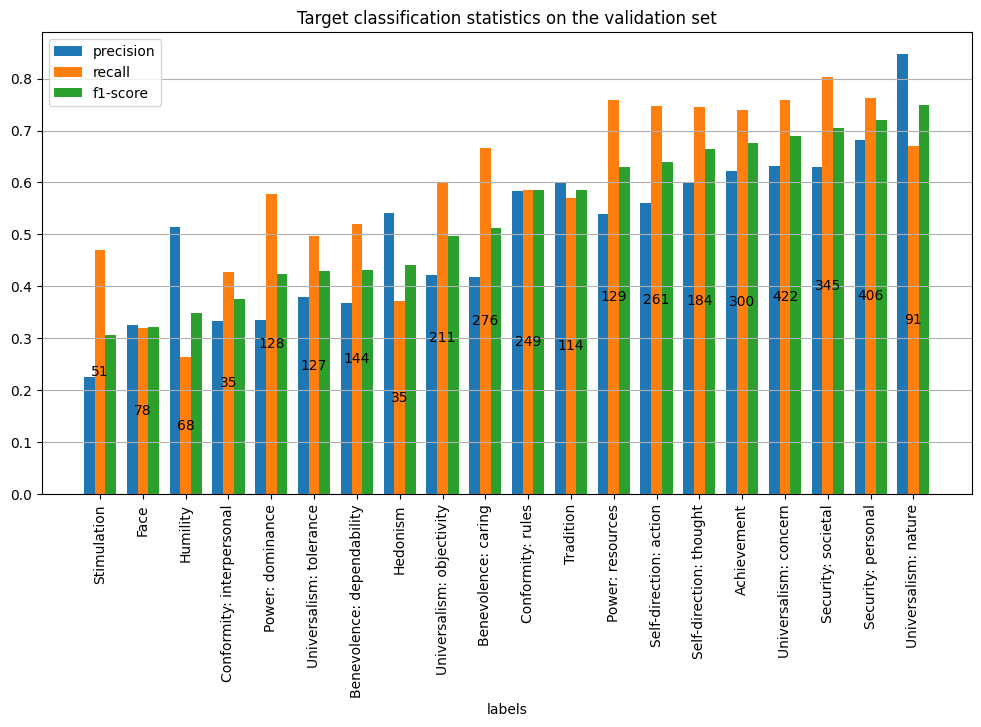

In [80]:
from utils.evaluation_analysis import plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'validation')


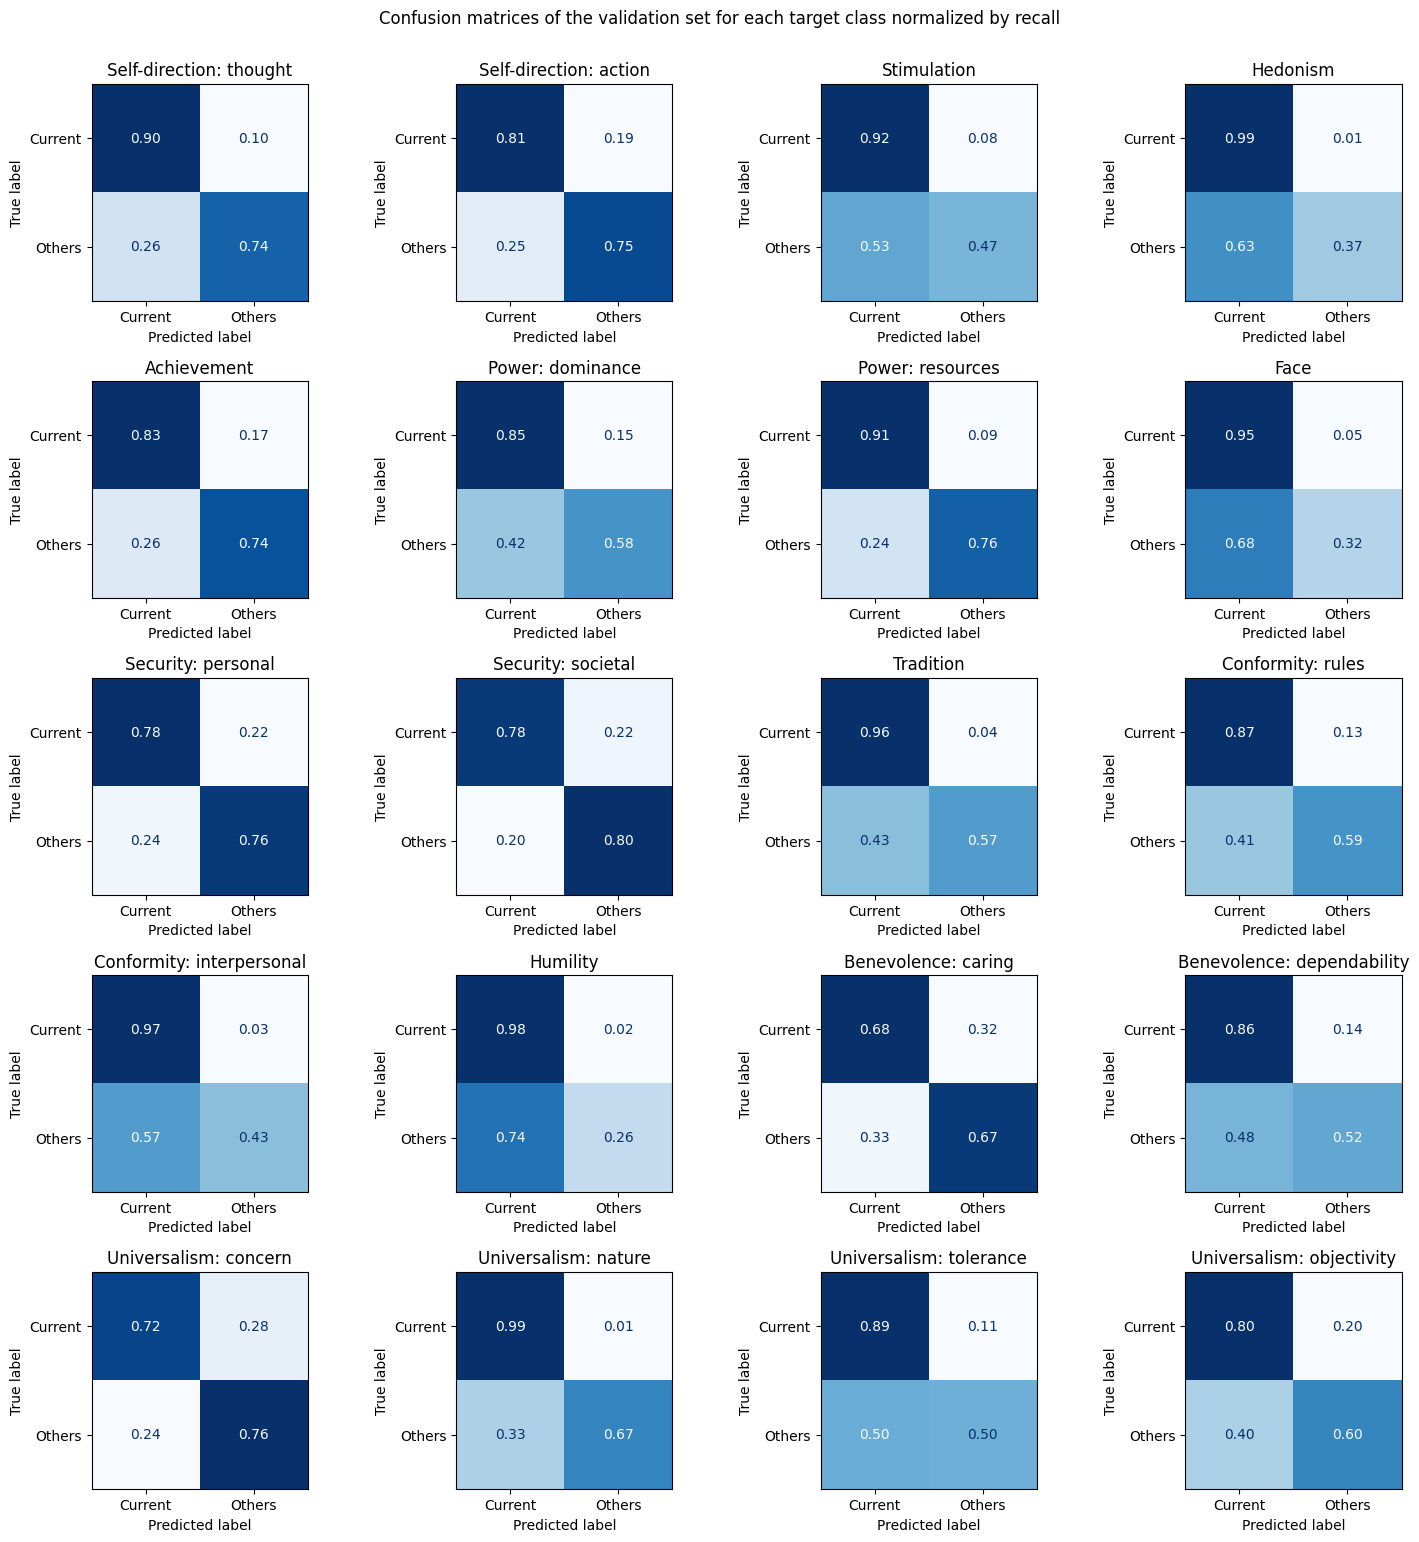

In [81]:
from utils.evaluation_analysis import plot_confusion_matrices
plot_confusion_matrices(y_true, y_pred, TARGETS, 'validation')

Macro-averaged One-vs-Rest ROC AUC score:
0.83


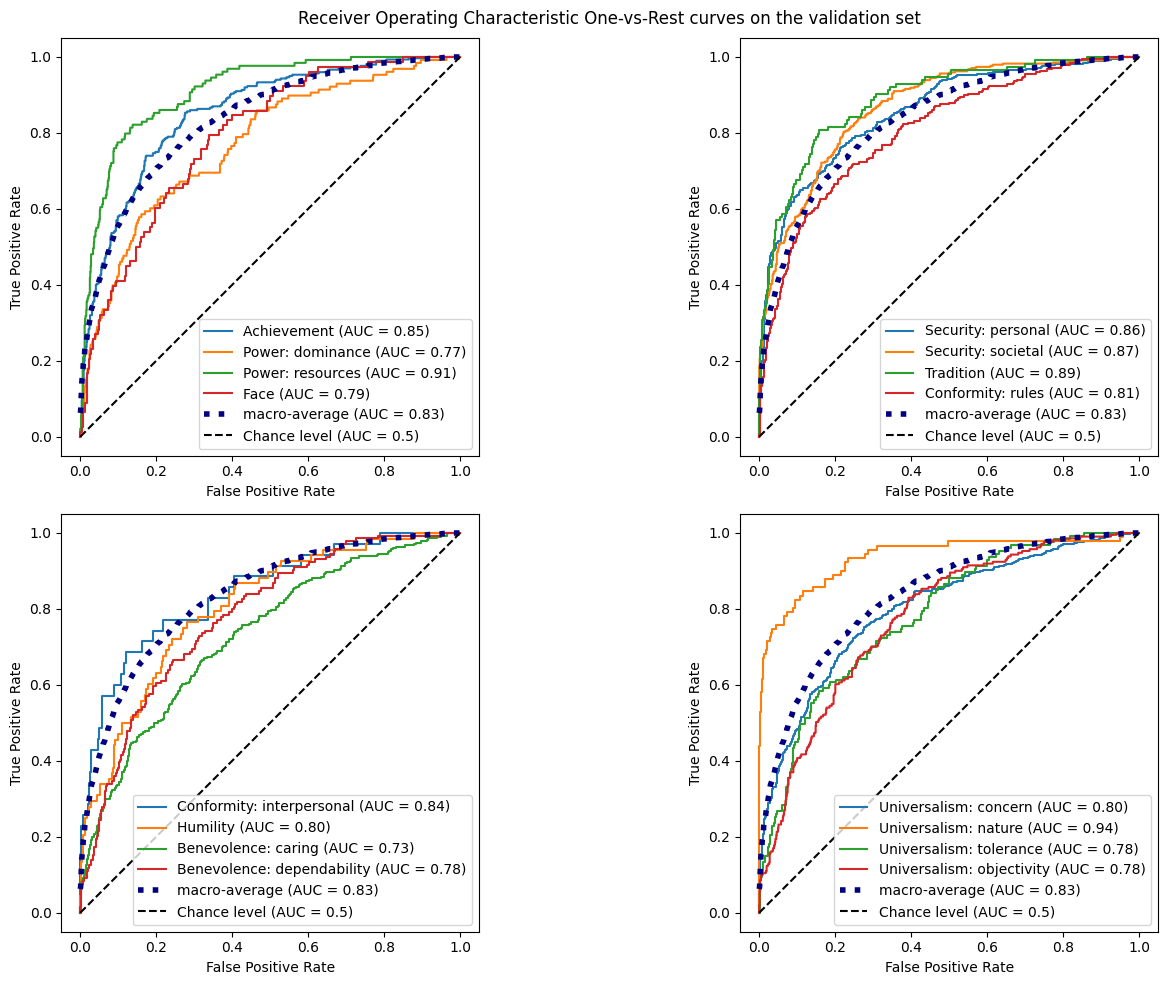

In [87]:
from utils.evaluation_analysis import plot_roc_curves

plot_roc_curves(y_true, preds, TARGETS, 'validation')

## Evaluation on the Test set

In [88]:
# Test f1-score
from sklearn.metrics import f1_score
from utils.evaluation import predict

y_pred, y_true = predict(model, test_loader, DEVICE)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Validation f1-score macro on the test set with base threshold 0: {f1_macro:.3f}')

Validation f1-score macro on the test set with base threshold 0: 0.458


In [90]:
# Validation f1-score + threshold
from sklearn.metrics import f1_score
from utils.evaluation import predict

#for i in np.linspace(-)

y_pred, y_true = predict(model, test_loader, DEVICE, threshold)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Validation f1-score macro on the test set with threshold selection: {f1_macro:.3f}')

Validation f1-score macro on the test set with threshold selection: 0.458


In [91]:
from utils.evaluation_analysis import print_classification_report

print_classification_report(y_true, y_pred, TARGETS, 'test')

Classification report for the test set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.37      0.71      0.49       251
    Self-direction: action       0.61      0.52      0.56       496
               Stimulation       0.30      0.30      0.30       138
                  Hedonism       0.34      0.33      0.34       103
               Achievement       0.68      0.63      0.65       575
          Power: dominance       0.28      0.32      0.30       164
          Power: resources       0.43      0.70      0.53       132
                      Face       0.16      0.59      0.26       130
        Security: personal       0.74      0.77      0.76       759
        Security: societal       0.61      0.69      0.65       488
                 Tradition       0.28      0.56      0.38       172
         Conformity: rules       0.45      0.76      0.57       455
 Conformity: interpersonal       0.12      0.38      0.19        60
       

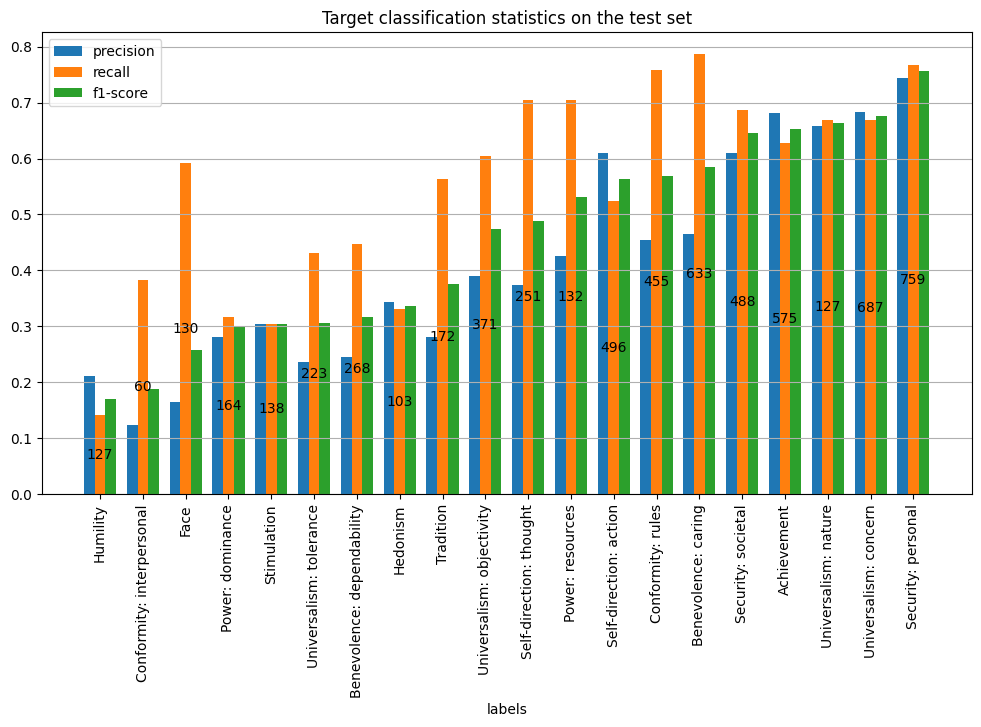

In [92]:
from utils.evaluation_analysis import plot_targets_classification_statistics

plot_targets_classification_statistics(y_true, y_pred, TARGETS, 'test')


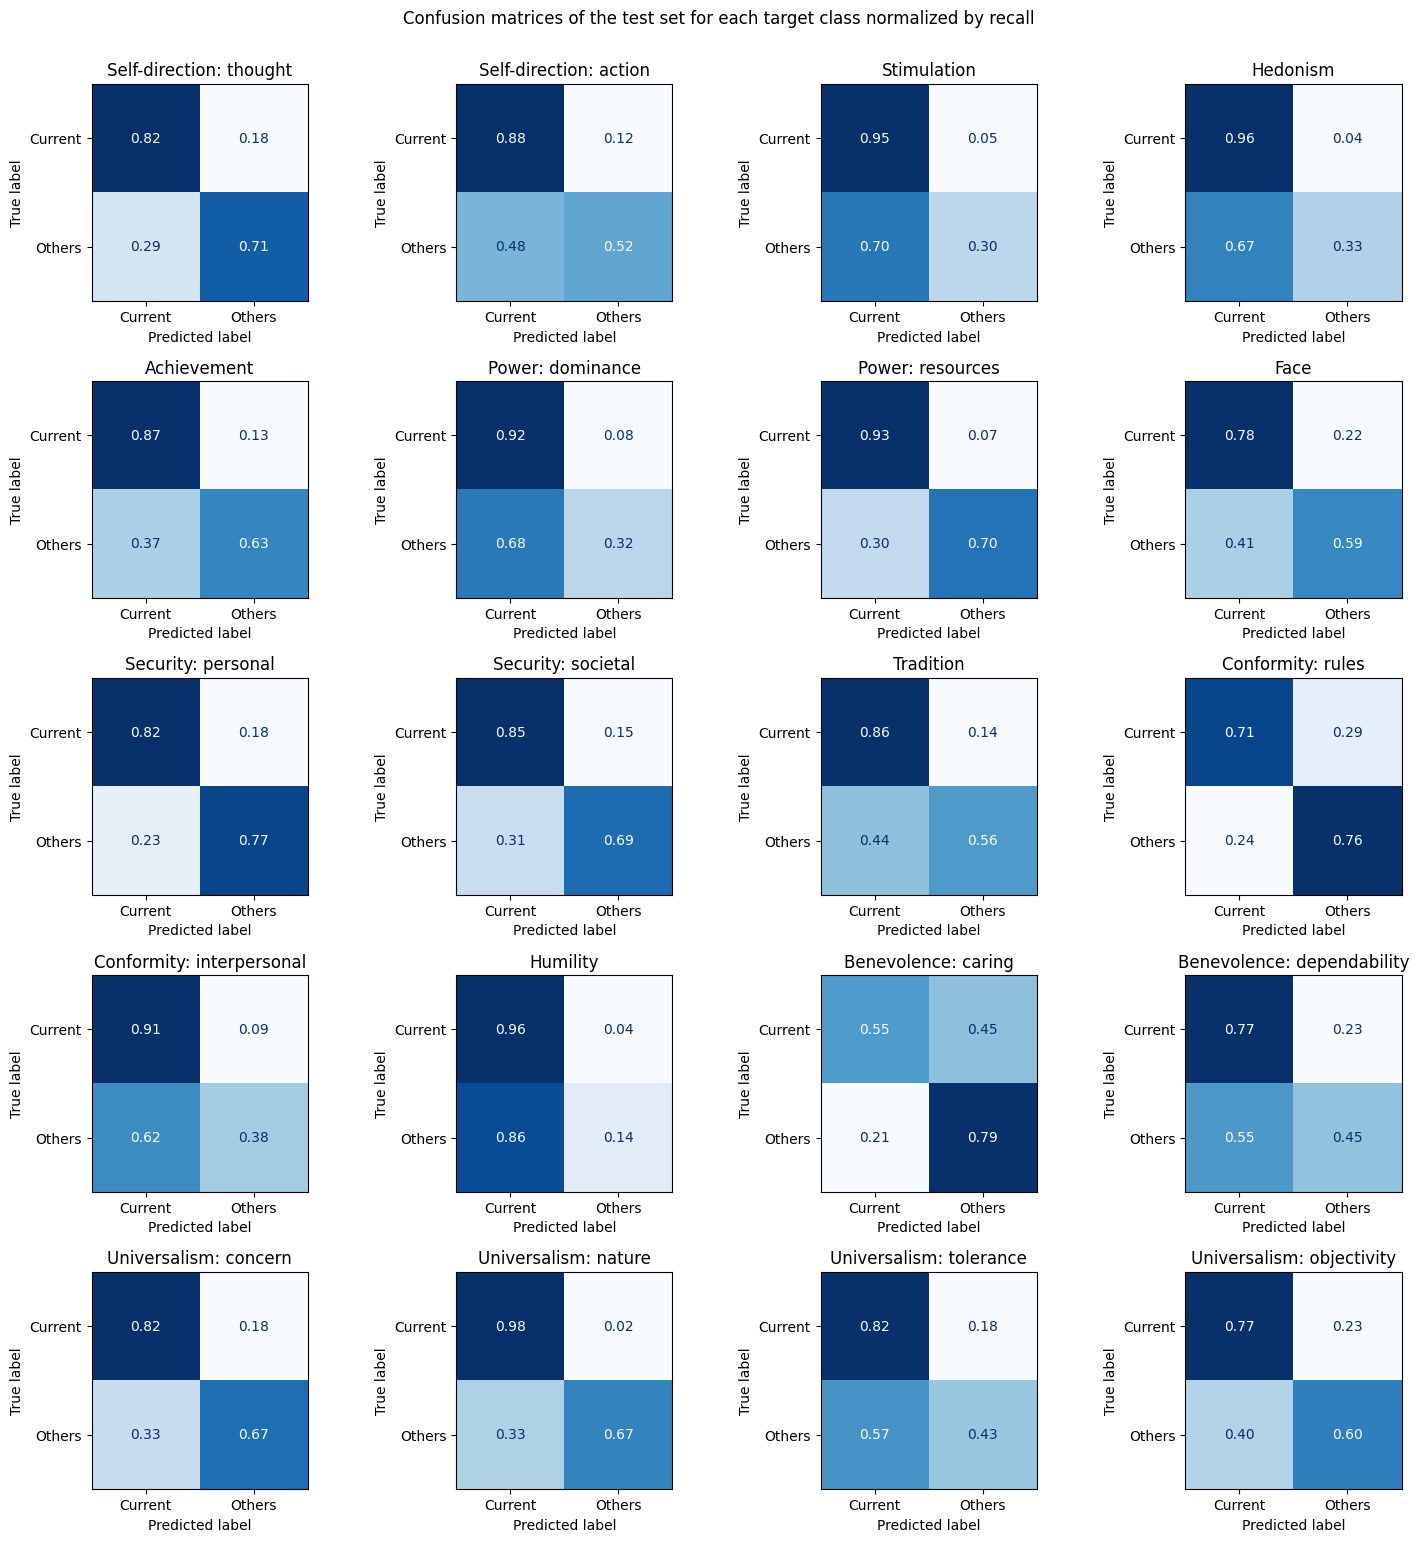

In [93]:
from utils.evaluation_analysis import plot_confusion_matrices
plot_confusion_matrices(y_true, y_pred, TARGETS, 'test')

Macro-averaged One-vs-Rest ROC AUC score:
0.79


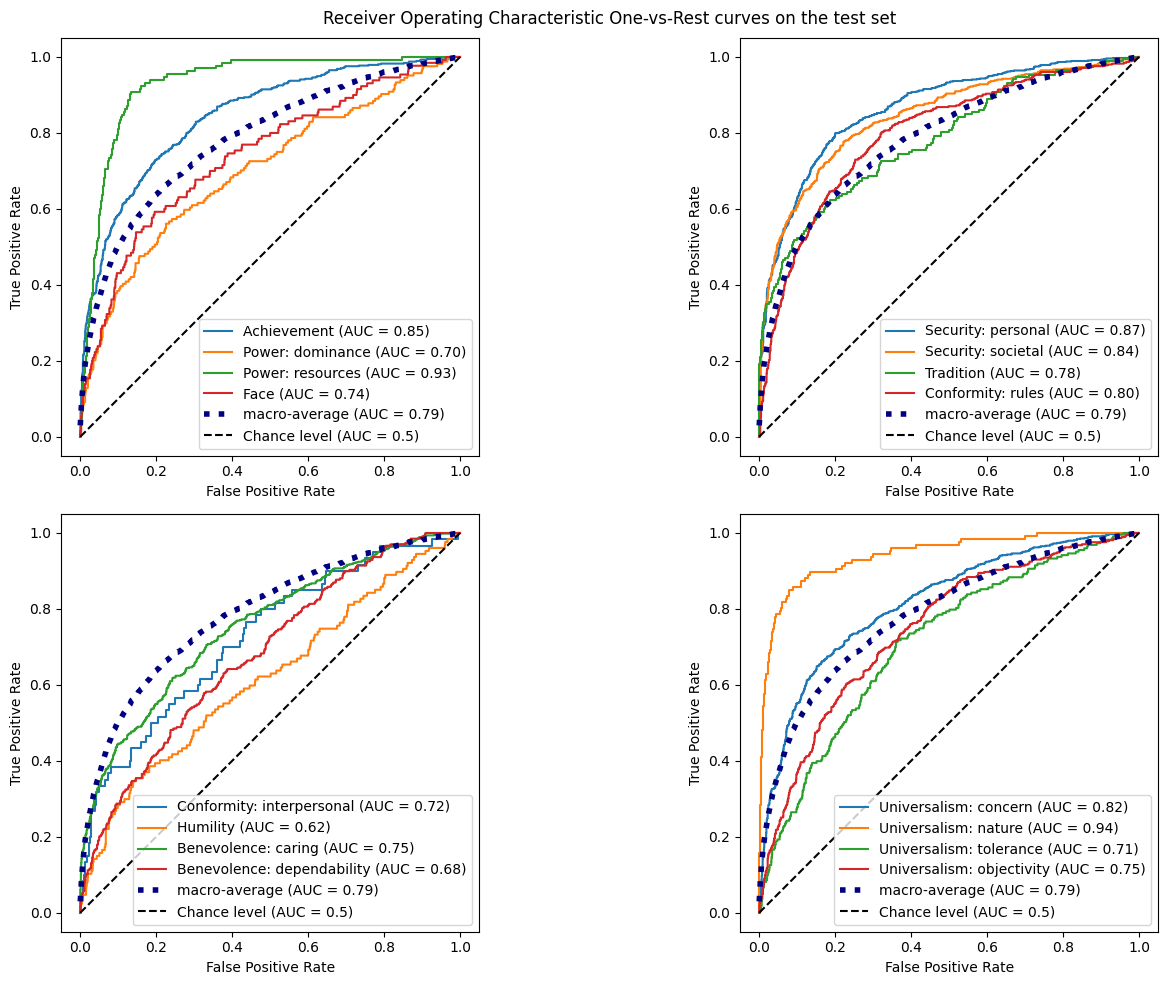

In [95]:
from utils.evaluation_analysis import plot_roc_curves

preds, y_true = get_dataset_predictions(model, test_loader, DEVICE)

plot_roc_curves(y_true, preds, TARGETS, 'test')